Segmented data provided by BGI.  
New data file `data_adjust_rna.txt`  
- x, y, gene_name, counts columns are the same  
- Added `label` column = cell id
- Added `tag` column, 0 = spot within nucleus of cell, 1 = spot in extended cell  
- Only contains spots that are part of a cell

Segmentation algorithm using QuPath to segment nucleus from ssDNA image  
Nucleus segmentation is then extended in some way to fill out the cell and capture transcripts that could have diffused  
Looks like they extend until it hits another cells or some size boundary

In [16]:
# Import some stuff
import os, sys
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
from collections import OrderedDict
from sawg import SpotTable

In [2]:
import PIL
PIL.Image.MAX_IMAGE_PIXELS = None

In [3]:
data_path = 'C:\\Users\stephanies\data\BGI_data'
data_file = data_path + '/903TR_C4/data_adjust_rna.txt'
cache_file = data_file + '.npz'

In [4]:
# add cell columns
# TODO: make a new attribute for 'in_cell'

cell_cols = {
    'cell_ids': 5,
    'in_cell': 6
}
cell_table = SpotTable.load_stereoseq(gem_file=data_file, cell_cols=cell_cols, skiprows=1, cache_file=cache_file)

Loading from npz..


In [5]:
spot_table = SpotTable.load_stereoseq(gem_file=data_path + '/903TR_C4/SS200000903TR_C4.tissue.gem', 
                                      cache_file=data_path + '/903TR_C4/SS200000903TR_C4.tissue.gem.npz')

Loading from npz..


In [81]:
# tr_matrix = np.array([[ 1.30468948, -0.05413256, -1000],
#        [ 0.05413256,  1.30468948, -770],])

# Transformation approach:
# Info from BGI states 0.65um / pixel on original microscope image
# Using BGI software ImageQC, get scale (1.304...) and rotation value from that
# Spots are spaced 500nm center to center
# Through trial and error of matching up spot table to image concluded that using a spot to pixel transformation divided by
# the scale had a close-ish match. Did not seem to need rotation. Segmented cell spots still don't see perfectly aligned to
# nuclei image.
# This only becomes relevant if we want to segement ourselves which is not unreasonable
# UPDATE (2/7/23): regist.tif file is already in spot coordinates

# spot_to_px = (650/500)/1.30468948
# tr_matrix = np.array([[ spot_to_px, 0, 0],
#        [ 0,  spot_to_px, 0],])

In [6]:
from sawg.image import Image, ImageTransform

mask_file = data_path + '/903TR_C4/C4_Mask.corr.tif'
img_file = data_path + '/903TR_C4/SS200000903TR_C4_20221223_102511_regist.tif'

no_tr = np.eye(3)[:2]
tr = ImageTransform(no_tr)
image= Image(file=img_file, transform=tr, axes=['frame', 'row', 'col', 'channel'], channels=['ssDNA'], name=None)
mask= Image(file=mask_file, transform=tr, axes=['frame', 'row', 'col', 'channel'], channels=['cell_mask'], name=None)

In [7]:
cell_table.images = []
cell_table.add_image(image)
cell_table.add_image(mask)

In [8]:
spot_table.add_image(image)
spot_table.add_image(mask)

C:\Users\stephanies\AppData\Local\Continuum\miniconda3\envs\stereoseq\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


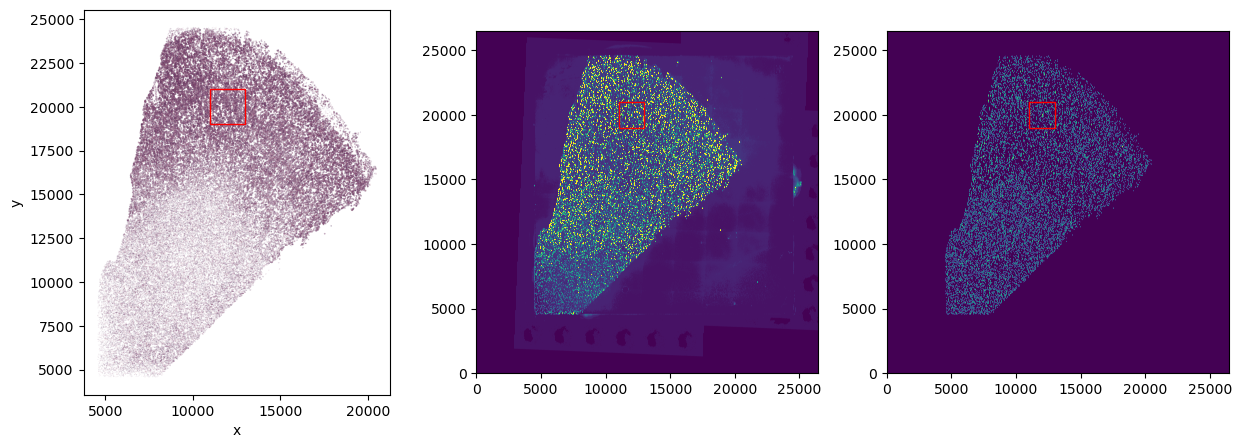

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sub = cell_table.get_subregion(xlim=(11000, 13000), ylim=(19000, 21000))
cell_table[::100].scatter_plot(ax=ax[0], alpha=0.1, size=0.5)
cell_table.get_image(channel='ssDNA').show(ax[1], vmax=20)#, frame='mean', cmap='gray')
cell_table.get_image(channel='cell_mask').show(ax[2])
[sub.plot_rect(a, 'r') for a in ax]

C:\Users\stephanies\AppData\Local\Continuum\miniconda3\envs\stereoseq\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\stephanies\AppData\Local\Continuum\miniconda3\envs\stereoseq\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[(18900.05, 21098.95), (18900.05, 21098.95)]

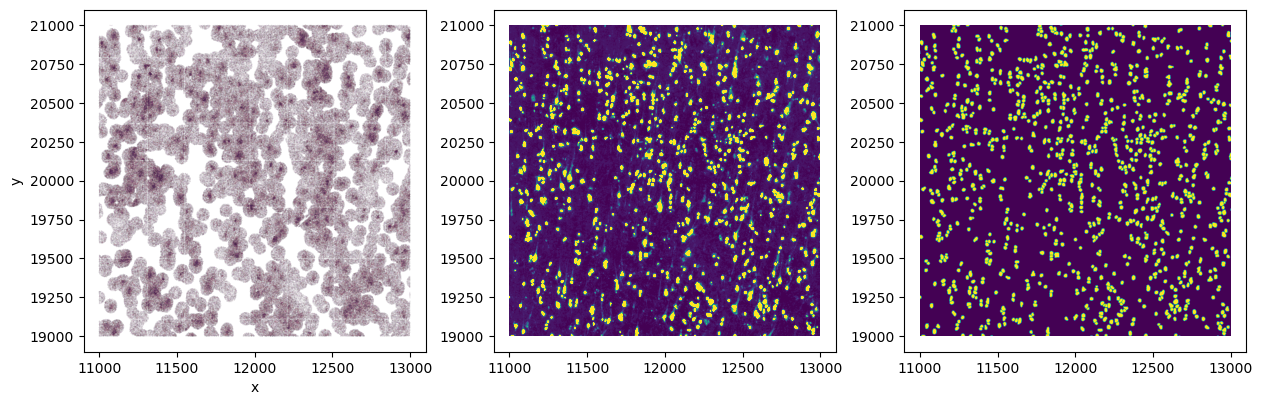

In [9]:
sub = cell_table.get_subregion(xlim=(11000, 13000), ylim=(19000, 21000))
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sub.scatter_plot(ax=ax[0], size=1, alpha=0.01)
sub.get_image(channel='ssDNA').show(ax=ax[1], vmax=20)
sub.get_image(channel='cell_mask').show(ax=ax[2])
xlims = ax[0].get_xlim()
ylims = ax[0].get_ylim()
[a.set_xlim(xlims) for a in ax[1:]]
[a.set_ylim(ylims) for a in ax[1:]]

C:\Users\stephanies\AppData\Local\Continuum\miniconda3\envs\stereoseq\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


[(19225.05, 19773.95), (19225.05, 19773.95)]

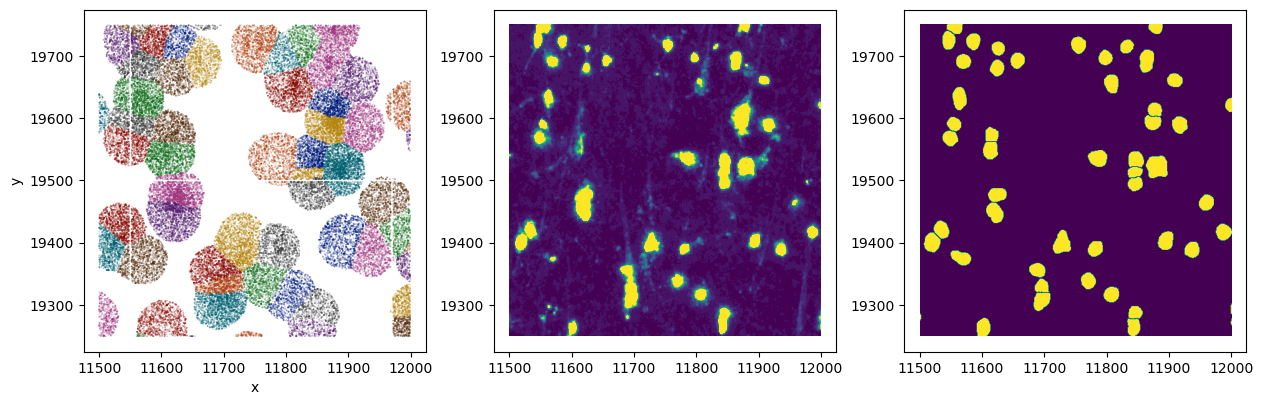

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sub2 = sub.get_subregion(xlim=(11500, 12000), ylim=(19250, 19750))
sub2.cell_scatter_plot(ax=ax[0])

sub2.get_image(channel='ssDNA').show(ax[1],vmax=20)# frame='mean', cmap='gray')
sub2.get_image(channel='cell_mask').show(ax[2])

xlims = ax[0].get_xlim()
ylims = ax[0].get_ylim()
[a.set_xlim(xlims) for a in ax[1:]]
[a.set_ylim(ylims) for a in ax[1:]]

C:\Users\stephanies\AppData\Local\Continuum\miniconda3\envs\stereoseq\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\stephanies\AppData\Local\Continuum\miniconda3\envs\stereoseq\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


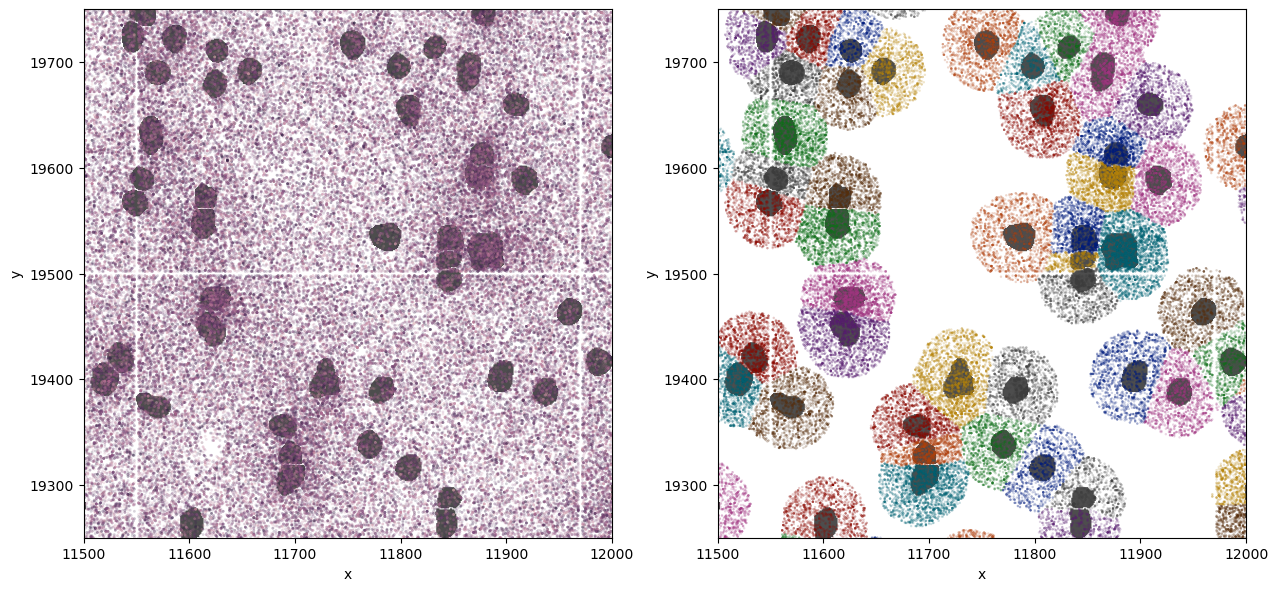

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
sub3 = spot_table.get_subregion(xlim=(11500, 12000), ylim=(19250, 19750))
sub3.get_image(channel='cell_mask').show(ax[0], cmap='gray_r', alpha=0.7)
sub3.scatter_plot(ax=ax[0], size=4)

sub2.get_image(channel='cell_mask').show(ax[1], cmap='gray_r', alpha=0.7)
sub2.cell_scatter_plot(ax=ax[1], size=3)

C:\Users\stephanies\AppData\Local\Continuum\miniconda3\envs\stereoseq\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\stephanies\AppData\Local\Continuum\miniconda3\envs\stereoseq\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


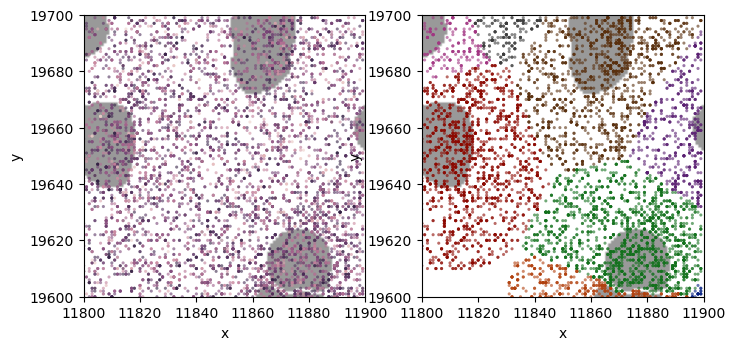

In [66]:
sub100bin_cell = sub2.get_subregion(xlim=(11800, 11900), ylim=(19600, 19700))
sub100bin_spot = sub3.get_subregion(xlim=(11800, 11900), ylim=(19600, 19700))

fig, ax  = plt.subplots(1, 2, figsize=(8, 4))
sub100bin_spot.get_image(channel='cell_mask').show(ax[0], cmap='gray_r', alpha=0.4)
sub100bin_spot.scatter_plot(ax=ax[0], size=5, alpha=0.6)
sub100bin_cell.get_image(channel='cell_mask').show(ax[1], cmap='gray_r', alpha=0.4)
sub100bin_cell.cell_scatter_plot(ax=ax[1], size=5, alpha=0.6)


C:\Users\stephanies\AppData\Local\Continuum\miniconda3\envs\stereoseq\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\stephanies\AppData\Local\Continuum\miniconda3\envs\stereoseq\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


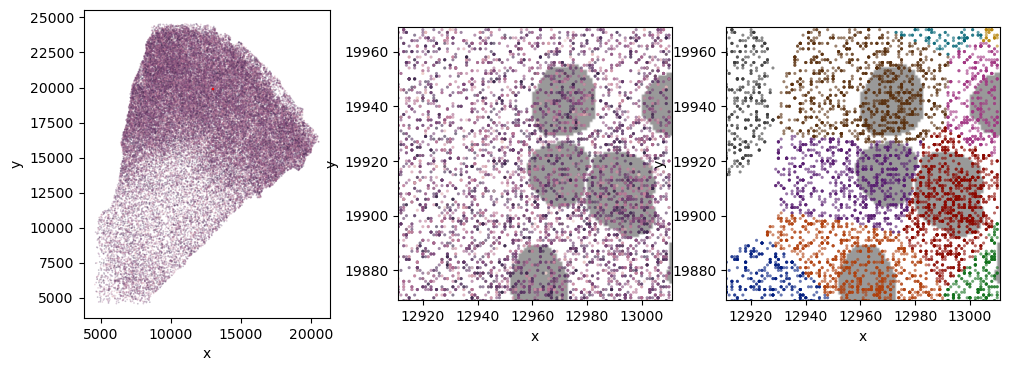

In [15]:
# Bin from mapping that produced interesting deconvolution results
sub100bin2_cell = cell_table.get_subregion(xlim=(12911, 12911+100), ylim=(19869, 19869+100))
sub100bin2_spot = spot_table.get_subregion(xlim=(12911, 12911+100), ylim=(19869, 19869+100))

fig, ax  = plt.subplots(1, 3, figsize=(12, 4))
spot_table[::1000].scatter_plot(ax=ax[0], alpha=0.3)
sub100bin2_spot.plot_rect(ax[0], 'r')
sub100bin2_spot.get_image(channel='cell_mask').show(ax[1], cmap='gray_r', alpha=0.4)
sub100bin2_spot.scatter_plot(ax=ax[1], size=5, alpha=0.6)
sub100bin2_cell.get_image(channel='cell_mask').show(ax[2], cmap='gray_r', alpha=0.4)
sub100bin2_cell.cell_scatter_plot(ax=ax[2], size=5, alpha=0.6)


In [59]:
np.unique(sub2.cell_ids)

array([40016, 40086, 40128, 40187, 40192, 40218, 40223, 40255, 40269,
       40297, 40340, 40384, 40393, 40452, 40497, 40501, 40537, 40543,
       40558, 40561, 40576, 40586, 40614, 40622, 40693, 40748, 40773,
       40814, 40872, 40873, 40910, 40913, 40946, 41003, 41004, 41021,
       41051, 41061, 41071, 41105, 41123, 41143, 41159, 41234, 41258,
       41312, 41322, 41342, 41343, 41355, 41394, 41404, 41409, 41426,
       41428, 41489, 41490, 41583], dtype=uint16)

In [10]:
# get some stats on approximate cell volume by seeing how many transcripts contribute to each cell

cell_ids, n_transcripts = np.unique(cell_table.cell_ids, return_counts=True)

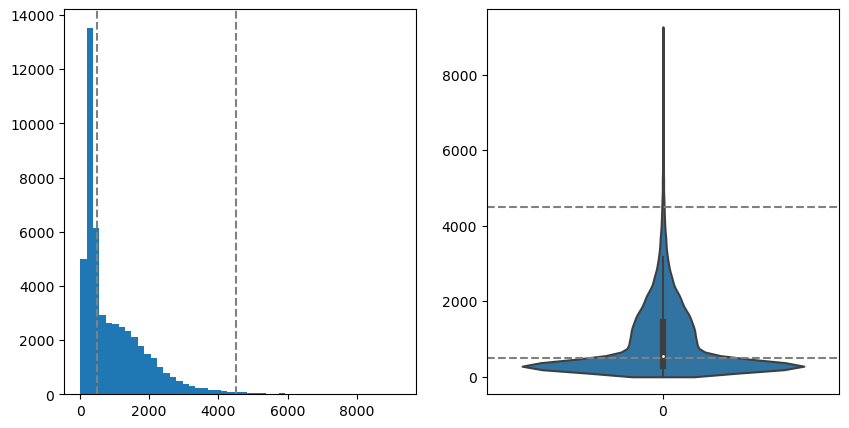

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
_ = ax[0].hist(n_transcripts, bins=50)
ax[0].axvline(500, ls='--', c='grey')
ax[0].axvline(4500, ls='--', c='grey')
sns.violinplot(data=n_transcripts, cut=0, ax=ax[1])
ax[1].axhline(500, ls='--', c='grey')
ax[1].axhline(4500, ls='--', c='grey')

In [119]:
cell = cell_table[cell_table.cell_mask([40072])]

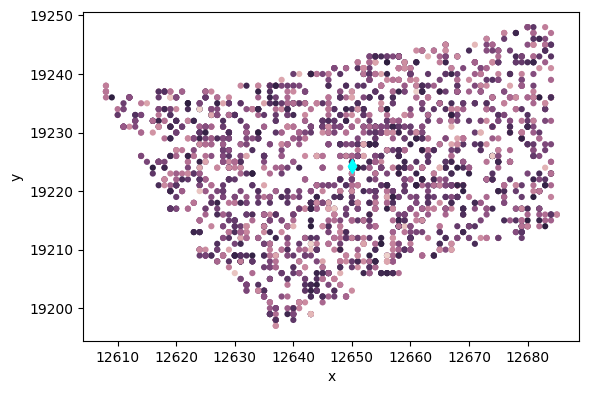

In [120]:
# calculate center of cell using avg of x and y position

x_center = cell.x.mean()
y_center = cell.y.mean()

fig, ax = plt.subplots()
cell.scatter_plot(ax=ax, size=20, alpha=1)
ax.scatter(x_center, y_center, marker='d', s=50, c='cyan')

In [149]:
# cell gene counts
cell_genes, counts = np.unique(cell.gene_names, return_counts=True)

n_transcripts = sum(counts)
n_genes = len(cell_genes)

# how many stereoseq spots contribute to this cell
n_spots = len(np.unique(cell.pos))

print(n_transcripts, n_genes, n_spots)

2739 1542 130


In [158]:
cell_genes

array(['ADGRG1', 'EPB41L4B', 'LINC02226', 'MT-ATP6', 'MT-CO2', 'MT-ND3',
       'RASAL2', 'RPS19', 'TAF15'], dtype='<U16')

In [5]:
# get all genes

all_genes = np.unique(cell_table.gene_names)

In [6]:
cbg_df = pd.DataFrame(0, index=cell_ids, columns=all_genes)
cbg_df.head()

A1BG  A1BG-AS1  A1CF  A2M  A2M-AS1  A2ML1  A2ML1-AS1  A3GALT2  A4GALT  \
1      0         0     0    0        0      0          0        0       0   
6      0         0     0    0        0      0          0        0       0   
9      0         0     0    0        0      0          0        0       0   
10     0         0     0    0        0      0          0        0       0   
11     0         0     0    0        0      0          0        0       0   

    A4GNT  ...  ZW10  ZWILCH  ZWINT  ZXDA  ZXDB  ZXDC  ZYG11A  ZYG11B  ZYX  \
1       0  ...     0       0      0     0     0     0       0       0    0   
6       0  ...     0       0      0     0     0     0       0       0    0   
9       0  ...     0       0      0     0     0     0       0       0    0   
10      0  ...     0       0      0     0     0     0       0       0    0   
11      0  ...     0       0      0     0     0     0       0       0    0   

    ZZEF1  
1       0  
6       0  
9       0  
10      0  
11      0  

[5 rows x 29634 columns]

In [13]:
cbg_meta = pd.DataFrame(index=cell_ids, columns=['x', 'y', 'n_spots', 'n_transcripts', 'n_genes'], dtype=float)
cbg_meta.head()

x   y  n_spots  n_transcripts  n_genes
1  NaN NaN      NaN            NaN      NaN
6  NaN NaN      NaN            NaN      NaN
9  NaN NaN      NaN            NaN      NaN
10 NaN NaN      NaN            NaN      NaN
11 NaN NaN      NaN            NaN      NaN

In [14]:
for cell_id in tqdm(cell_ids):
    cell = cell_table[cell_table.cell_mask([cell_id])]
    cbg_meta.loc[cell_id]['x'] = cell.x.mean()
    cbg_meta.loc[cell_id]['y'] = cell.y.mean()
    cbg_meta.loc[cell_id]['n_spots'] = len(np.unique(cell.pos))

    cell_genes, gene_counts = np.unique(cell.gene_names, return_counts=True)
    cbg_meta.loc[cell_id]['n_transcripts'] = sum(gene_counts)
    cbg_meta.loc[cell_id]['n_genes'] = len(cell_genes)
#     cbg_df.loc[cell_id][cell_genes] = gene_counts

  0%|          | 0/49532 [00:00<?, ?it/s]

In [76]:
cbg_meta = cbg_meta.astype(float)
cbg_meta.index = cbg_meta.index.astype(str)
print(cbg_meta.index.dtype)
cbg_meta.head()

object


x_center     y_center  n_spots  n_transcripts  n_genes
1   5815.666504  4578.666504      6.0            3.0      3.0
6   4868.000000  4565.666504      5.0            3.0      3.0
9   5776.777832  4572.777832     12.0            9.0      7.0
10  7874.111328  4574.777832     13.0            9.0      9.0
11  5580.714355  4581.000000      8.0            7.0      6.0

In [13]:
cbg_df.head(10)

A1BG  A1BG-AS1  A1CF  A2M  A2M-AS1  A2ML1  A2ML1-AS1  A3GALT2  A4GALT  \
1      0         0     0    0        0      0          0        0       0   
6      0         0     0    0        0      0          0        0       0   
9      0         0     0    0        0      0          0        0       0   
10     0         0     0    0        0      0          0        0       0   
11     0         0     0    0        0      0          0        0       0   
12     0         0     0    0        0      0          0        0       0   
15     0         0     0    0        0      0          0        0       0   
16     0         0     0    0        0      0          0        0       0   
17     0         0     0    0        0      0          0        0       0   
18     0         0     0    0        0      0          0        0       0   

    A4GNT  ...  ZW10  ZWILCH  ZWINT  ZXDA  ZXDB  ZXDC  ZYG11A  ZYG11B  ZYX  \
1       0  ...     0       0      0     0     0     0       0       0    0   
6       0  ...     0       0      0     0     0     0       0       0    0   
9       0  ...     0       0      0     0     0     0       0       0    0   
10      0  ...     0       0      0     0     0     0       0       0    0   
11      0  ...     0       0      0     0     0     0       0       0    0   
12      0  ...     0       0      0     0     0     0       0       0    0   
15      0  ...     0       0      0     0     0     0       0       0    0   
16      0  ...     0       0      0     0     0     0       0       0    0   
17      0  ...     0       0      0     0     0     0       0       0    0   
18      0  ...     0       0      0     0     0     0       0       0    0   

    ZZEF1  
1       0  
6       0  
9       0  
10      0  
11      0  
12      0  
15      0  
16      0  
17      0  
18      0  

[10 rows x 29634 columns]

In [79]:
cbg_df.index = cbg_df.index.astype(str)

In [32]:
# cbg_df.to_csv(data_path + '/903TR_C4/cell_gene_table.csv')
cbg_meta = pd.read_csv(data_path + '/903TR_C4/cell_metadata.csv')
cbg_meta.rename(columns={'Unnamed: 0': 'sample_id'}, inplace=True)
cbg_meta.set_index('sample_id', inplace=True)
cbg_meta.head()

x            y  n_spots  n_transcripts  n_genes
sample_id                                                           
1          5815.666504  4578.666504      6.0            3.0      3.0
6          4868.000000  4565.666504      5.0            3.0      3.0
9          5776.777832  4572.777832     12.0            9.0      7.0
10         7874.111328  4574.777832     13.0            9.0      9.0
11         5580.714355  4581.000000      8.0            7.0      6.0

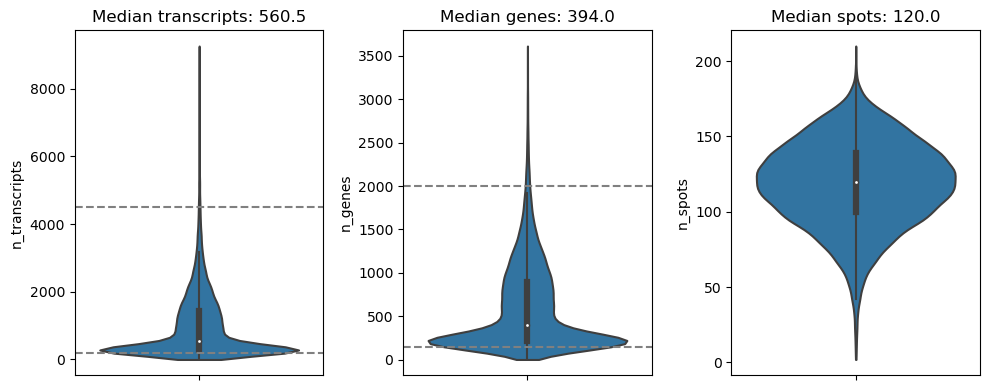

In [15]:
qc_params = {'n_genes': [150, 2000], 'n_transcripts': [200, 4500]}

fig, ax = plt.subplots(1, 3, figsize=(10, 4))

sns.violinplot(data=cbg_meta, y='n_transcripts', cut=0, ax=ax[0])
[ax[0].axhline(bound, c='grey', ls='--') for bound in qc_params['n_transcripts']]
ax[0].set_title(f"Median transcripts: {cbg_meta['n_transcripts'].median()}")
sns.violinplot(data=cbg_meta, y='n_genes', cut=0, ax=ax[1])
[ax[1].axhline(bound, c='grey', ls='--') for bound in qc_params['n_genes']]
ax[1].set_title(f"Median genes: {cbg_meta['n_genes'].median()}")
sns.violinplot(data=cbg_meta, y='n_spots', cut=0, ax=ax[2])
ax[2].set_title(f"Median spots: {cbg_meta['n_spots'].median()}")
plt.tight_layout()

In [88]:
qc_pass = cbg_meta['n_transcripts'].between(qc_params['n_transcripts'][0], qc_params['n_transcripts'][1]) & cbg_meta['n_genes'].between(qc_params['n_genes'][0], qc_params['n_genes'][1])
cbg_filtered = cbg_df[qc_pass]
cbg_meta_filtered = cbg_meta[qc_pass]

Text(0.5, 1.0, 'QC Pass: 42646')

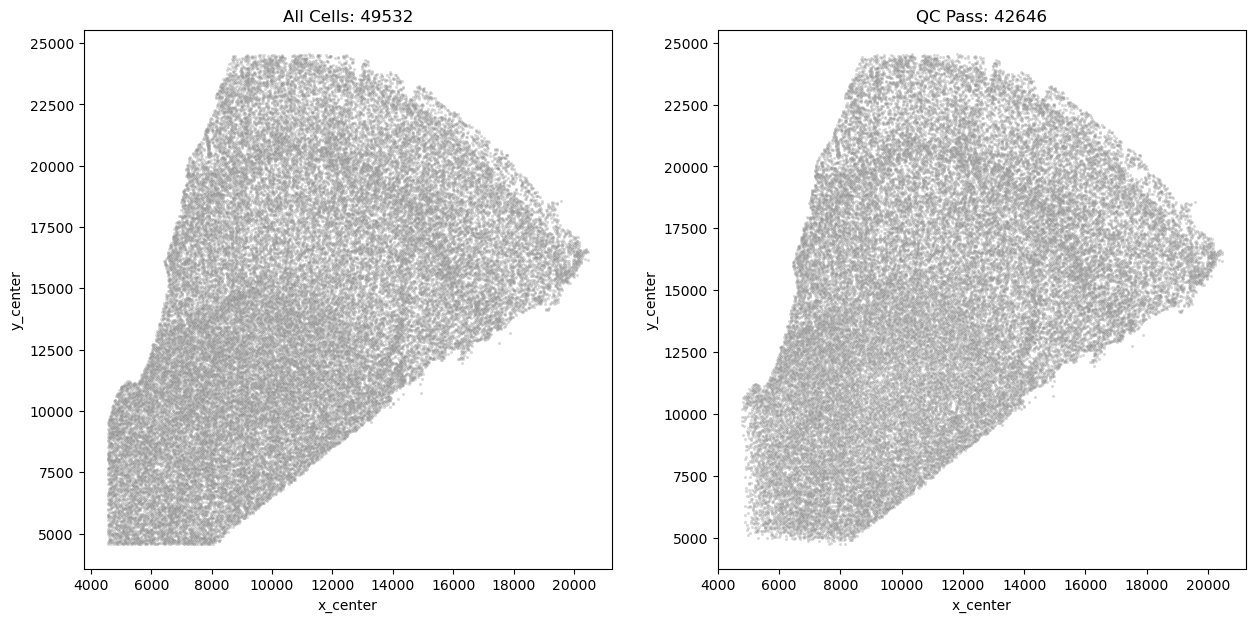

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.scatterplot(data=cbg_meta, x='x', y='y', color='grey', s=5, alpha=0.3, ax=ax[0])
ax[0].set_title(f'All Cells: {len(cbg_meta)}')
sns.scatterplot(data=cbg_meta_filtered, x='x', y='y', color='grey', s=5, alpha=0.3, ax=ax[1])
ax[1].set_title(f'QC Pass: {len(cbg_meta_filtered)}')

In [89]:
# create anndata objects
exp_meta = {
    'method': 'BGI Stereoseq',
    'segmentation': 'BGI provided',
    'qc_params': qc_params,
    'Species': 'Human',
    'Pathology': 'neuortypical',
    'ROI': 'MTG'
}

ad_sp = ad.AnnData(
        X = cbg_filtered,
        obs = cbg_meta_filtered,
        uns = OrderedDict(exp_meta),
    )

ad_sp.obs_names = cbg_filtered.index.astype('str')
ad_sp.var_names = cbg_filtered.columns

C:\Users\stephanies\AppData\Local\Temp\ipykernel_30384\448626997.py:11: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad_sp = ad.AnnData(


In [90]:
ad_sp.write_h5ad(data_path + '/903TR_C4/sp_anndata.h5ad')

In [34]:
ad_sp_stereo = ad.read_h5ad(data_path + '/903TR_C4/sp_anndata.h5ad')

snRNAseq data from shiny

In [4]:
shiny_data_file = '//allen/programs/celltypes/workgroups/rnaseqanalysis/Nik/Analyses_for_great_apes_paper/Shiny_obj_final/human/data.feather'
shiny_anno_file = '//allen/programs/celltypes/workgroups/rnaseqanalysis/Nik/Analyses_for_great_apes_paper/Shiny_obj_final/human/anno.feather'

In [5]:
shiny_data = pd.read_feather(shiny_data_file)
shiny_data.head()

sample_id  3.8-1.2  3.8-1.3  3.8-1.4  3.8-1.5  \
0   CATGCTCGTCCAGCGT-6LKTX_191204_01_F01      0.0      0.0      0.0      0.0   
1  TAGCACACAGGCGTTC-11LKTX_191204_02_C01      0.0      0.0      0.0      0.0   
2   GGCTTGGCATACACCA-1LKTX_191204_01_A01      0.0      0.0      0.0      0.0   
3  TGTGAGTCAGACCTAT-10LKTX_191204_02_B01      0.0      0.0      0.0      0.0   
4  AATTCCTCAATTGCTG-35L8TX_191126_02_H02      0.0      0.0      0.0      0.0   

   5-HT3C2  A1BG  A1BG-AS1  A1CF  A2M  ...  ZXDB  ZXDC  ZYG11A  ZYG11AP1  \
0      0.0   0.0       0.0   0.0  1.0  ...   0.0   0.0     0.0       0.0   
1      0.0   0.0       0.0   0.0  0.0  ...   0.0   0.0     0.0       0.0   
2      0.0   0.0       0.0   0.0  0.0  ...   0.0   0.0     0.0       0.0   
3      0.0   0.0       0.0   0.0  0.0  ...   0.0   0.0     0.0       0.0   
4      0.0   0.0       0.0   0.0  0.0  ...   0.0   0.0     0.0       0.0   

   ZYG11B  ZYX  ZZEF1  ZZZ3  bA255A11.4  bA395L14.12  
0     0.0  0.0    0.0   0.0         0.0          0.0  
1     0.0  0.0    0.0   0.0         0.0          0.0  
2     0.0  0.0    0.0   1.0         0.0          0.0  
3     0.0  1.0    1.0   0.0         0.0          0.0  
4     3.0  0.0    0.0   2.0         0.0          0.0  

[5 rows x 50282 columns]

In [8]:
shiny_data.set_index('sample_id', inplace=True)
shiny_data.head()

3.8-1.2  3.8-1.3  3.8-1.4  3.8-1.5  \
sample_id                                                                   
CATGCTCGTCCAGCGT-6LKTX_191204_01_F01       0.0      0.0      0.0      0.0   
TAGCACACAGGCGTTC-11LKTX_191204_02_C01      0.0      0.0      0.0      0.0   
GGCTTGGCATACACCA-1LKTX_191204_01_A01       0.0      0.0      0.0      0.0   
TGTGAGTCAGACCTAT-10LKTX_191204_02_B01      0.0      0.0      0.0      0.0   
AATTCCTCAATTGCTG-35L8TX_191126_02_H02      0.0      0.0      0.0      0.0   

                                       5-HT3C2  A1BG  A1BG-AS1  A1CF  A2M  \
sample_id                                                                   
CATGCTCGTCCAGCGT-6LKTX_191204_01_F01       0.0   0.0       0.0   0.0  1.0   
TAGCACACAGGCGTTC-11LKTX_191204_02_C01      0.0   0.0       0.0   0.0  0.0   
GGCTTGGCATACACCA-1LKTX_191204_01_A01       0.0   0.0       0.0   0.0  0.0   
TGTGAGTCAGACCTAT-10LKTX_191204_02_B01      0.0   0.0       0.0   0.0  0.0   
AATTCCTCAATTGCTG-35L8TX_191126_02_H02      0.0   0.0       0.0   0.0  0.0   

                                       A2M-AS1  ...  ZXDB  ZXDC  ZYG11A  \
sample_id                                       ...                       
CATGCTCGTCCAGCGT-6LKTX_191204_01_F01       0.0  ...   0.0   0.0     0.0   
TAGCACACAGGCGTTC-11LKTX_191204_02_C01      0.0  ...   0.0   0.0     0.0   
GGCTTGGCATACACCA-1LKTX_191204_01_A01       0.0  ...   0.0   0.0     0.0   
TGTGAGTCAGACCTAT-10LKTX_191204_02_B01      0.0  ...   0.0   0.0     0.0   
AATTCCTCAATTGCTG-35L8TX_191126_02_H02      0.0  ...   0.0   0.0     0.0   

                                       ZYG11AP1  ZYG11B  ZYX  ZZEF1  ZZZ3  \
sample_id                                                                   
CATGCTCGTCCAGCGT-6LKTX_191204_01_F01        0.0     0.0  0.0    0.0   0.0   
TAGCACACAGGCGTTC-11LKTX_191204_02_C01       0.0     0.0  0.0    0.0   0.0   
GGCTTGGCATACACCA-1LKTX_191204_01_A01        0.0     0.0  0.0    0.0   1.0   
TGTGAGTCAGACCTAT-10LKTX_191204_02_B01       0.0     0.0  1.0    1.0   0.0   
AATTCCTCAATTGCTG-35L8TX_191126_02_H02       0.0     3.0  0.0    0.0   2.0   

                                       bA255A11.4  bA395L14.12  
sample_id                                                       
CATGCTCGTCCAGCGT-6LKTX_191204_01_F01          0.0          0.0  
TAGCACACAGGCGTTC-11LKTX_191204_02_C01         0.0          0.0  
GGCTTGGCATACACCA-1LKTX_191204_01_A01          0.0          0.0  
TGTGAGTCAGACCTAT-10LKTX_191204_02_B01         0.0          0.0  
AATTCCTCAATTGCTG-35L8TX_191126_02_H02         0.0          0.0  

[5 rows x 50281 columns]

In [9]:
shiny_meta = pd.read_feather(shiny_anno_file)
shiny_meta.set_index('sample_id', inplace=True)
shiny_meta.head()

class_label neighborhood_label  \
sample_id                                                              
CATGCTCGTCCAGCGT-6LKTX_191204_01_F01         glia               glia   
TAGCACACAGGCGTTC-11LKTX_191204_02_C01        glia               glia   
GGCTTGGCATACACCA-1LKTX_191204_01_A01         glia               glia   
TGTGAGTCAGACCTAT-10LKTX_191204_02_B01        glia               glia   
AATTCCTCAATTGCTG-35L8TX_191126_02_H02        glia               glia   

                                      cluster_label nCount_RNA_label  \
sample_id                                                              
CATGCTCGTCCAGCGT-6LKTX_191204_01_F01    Micro-PVM_1             2016   
TAGCACACAGGCGTTC-11LKTX_191204_02_C01   Micro-PVM_1             1313   
GGCTTGGCATACACCA-1LKTX_191204_01_A01    Micro-PVM_1             1861   
TGTGAGTCAGACCTAT-10LKTX_191204_02_B01   Micro-PVM_1             1733   
AATTCCTCAATTGCTG-35L8TX_191126_02_H02   Micro-PVM_1             7602   

                                      nFeature_RNA_label dataset_label  \
sample_id                                                                
CATGCTCGTCCAGCGT-6LKTX_191204_01_F01                1310          Sten   
TAGCACACAGGCGTTC-11LKTX_191204_02_C01                974          Sten   
GGCTTGGCATACACCA-1LKTX_191204_01_A01                1244          Sten   
TGTGAGTCAGACCTAT-10LKTX_191204_02_B01               1184          Sten   
AATTCCTCAATTGCTG-35L8TX_191126_02_H02               3159    AIBS_nonL5   

                                      donor_label species_label tech_label  \
sample_id                                                                    
CATGCTCGTCCAGCGT-6LKTX_191204_01_F01   H19.30.001         human      10Xv3   
TAGCACACAGGCGTTC-11LKTX_191204_02_C01  H19.30.002         human      10Xv3   
GGCTTGGCATACACCA-1LKTX_191204_01_A01   H18.30.002         human      10Xv3   
TGTGAGTCAGACCTAT-10LKTX_191204_02_B01  H19.30.001         human      10Xv3   
AATTCCTCAATTGCTG-35L8TX_191126_02_H02  H19.30.001         human    NextGEM   

                                      species_tech_label  ... tech_color  \
sample_id                                                 ...              
CATGCTCGTCCAGCGT-6LKTX_191204_01_F01           human_10x  ...    #3DCC3D   
TAGCACACAGGCGTTC-11LKTX_191204_02_C01          human_10x  ...    #3DCC3D   
GGCTTGGCATACACCA-1LKTX_191204_01_A01           human_10x  ...    #3DCC3D   
TGTGAGTCAGACCTAT-10LKTX_191204_02_B01          human_10x  ...    #3DCC3D   
AATTCCTCAATTGCTG-35L8TX_191126_02_H02          human_10x  ...    #171799   

                                      species_tech_color neighborhood_color  \
sample_id                                                                     
CATGCTCGTCCAGCGT-6LKTX_191204_01_F01             #FF7373            #FF7373   
TAGCACACAGGCGTTC-11LKTX_191204_02_C01            #FF7373            #FF7373   
GGCTTGGCATACACCA-1LKTX_191204_01_A01             #FF7373            #FF7373   
TGTGAGTCAGACCTAT-10LKTX_191204_02_B01            #FF7373            #FF7373   
AATTCCTCAATTGCTG-35L8TX_191126_02_H02            #FF7373            #FF7373   

                                      layer_color  s_color  class_color  \
sample_id                                                                 
CATGCTCGTCCAGCGT-6LKTX_191204_01_F01      #FF7373  #3DCCCC      #3DCC3D   
TAGCACACAGGCGTTC-11LKTX_191204_02_C01     #FF7373  #3DCCCC      #3DCC3D   
GGCTTGGCATACACCA-1LKTX_191204_01_A01      #FF7373  #3DCCCC      #3DCC3D   
TGTGAGTCAGACCTAT-10LKTX_191204_02_B01     #FF7373  #3DCCCC      #3DCC3D   
AATTCCTCAATTGCTG-35L8TX_191126_02_H02     #FF7373  #3DCCCC      #3DCC3D   

                                       donor_color  \
sample_id                                            
CATGCTCGTCCAGCGT-6LKTX_191204_01_F01       #9ECAE1   
TAGCACACAGGCGTTC-11LKTX_191204_02_C01      #6BAED6   
GGCTTGGCATACACCA-1LKTX_191204_01_A01       #C6DBEF   
TGTGAGTCAGACCTAT-10LKTX_191204_02_B01      #9ECAE1   
AATTCCTCAATTGCTG-35L8TX_1

In [11]:
ad_sc = ad.AnnData(
    X = shiny_data,
    obs = shiny_meta,
    uns = OrderedDict({
        'data_source': '//allen/programs/celltypes/workgroups/rnaseqanalysis/Nik/Analyses_for_great_apes_paper/Shiny_obj_final/human/data.feather',
        'region': 'MTG',
        'species': 'human',
        'method': '10X V3 Nuclear FACS',
        'project': 'Great Apes Study; downsampled to 1000 cells/cluster max'
    })
)

ad_sc.obs_names = shiny_meta.index.astype('str')
ad_sc.var_names = shiny_data.columns

C:\Users\stephanies\AppData\Local\Temp\ipykernel_28304\3233610843.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad_sc = ad.AnnData(


In [19]:
ad_sp = ad.read_h5ad(data_path + '/903TR_C4/sp_anndata.h5ad')
ad_sc = ad.read_h5ad('C://Users/stephanies/data/human/ad_sc_human_MTG_great_ape.h5ad')

Cell-wise gene expression comparison

In [20]:
mean_expression = pd.DataFrame(ad_sp.to_df().mean(), columns=['Stereoseq'])

In [21]:
mean_expression = mean_expression.merge(pd.DataFrame(ad_sc.to_df().mean(), columns=['snRNAseq']), left_index=True, right_index=True, how='outer')
mean_expression.fillna(0, inplace=True)
mean_expression = mean_expression[mean_expression['snRNAseq']>0]
mean_expression.head()

Stereoseq  snRNAseq
A1BG       0.026661  0.113253
A1BG-AS1   0.010833  0.074725
A1CF       0.000657  0.011534
A2M        0.080500  0.185429
A2M-AS1    0.001618  0.043627

In [144]:
# correlation with dropouts
mean_expression.corr()

Stereoseq  snRNAseq
Stereoseq   1.000000  0.251045
snRNAseq    0.251045  1.000000

In [145]:
dropouts = mean_expression[mean_expression['Stereoseq']==0]
dropouts.head()

Stereoseq  snRNAseq
A2MP1           0.0  0.030825
AACSP1          0.0  0.012965
AADACP1         0.0  0.001227
AATK-AS1        0.0  0.151536
ABCA11P         0.0  0.833467

In [146]:
dropouts.describe()

Stereoseq      snRNAseq
count    15363.0  15363.000000
mean         0.0      0.102379
std          0.0      0.487063
min          0.0      0.000014
25%          0.0      0.001023
50%          0.0      0.007171
75%          0.0      0.042850
max          0.0     20.121569

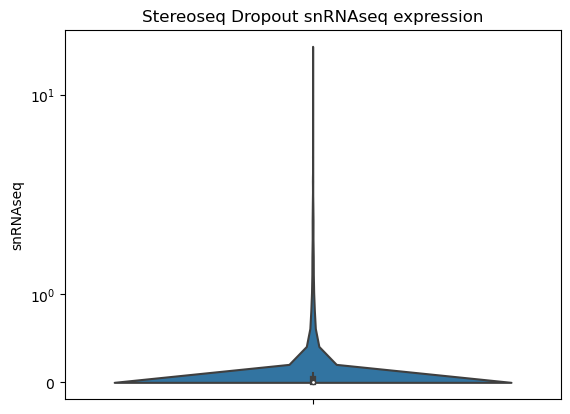

In [157]:
fig, ax = plt.subplots()
sns.violinplot(data=dropouts, y='snRNAseq', ax=ax, cut=0),
ax.set_yscale('symlog')
_ = ax.set_title('Stereoseq Dropout snRNAseq expression')

In [22]:
mean_expression = mean_expression[mean_expression['Stereoseq']>0]
for col in mean_expression.columns:
    mean_expression[col + ' log'] = np.log(mean_expression[col])
mean_expression['Ratio'] = mean_expression.apply(lambda x: x['Stereoseq'] / x['snRNAseq'], axis=1)
mean_expression.head()

Stereoseq  snRNAseq  Stereoseq log  snRNAseq log     Ratio
A1BG       0.026661  0.113253      -3.624540     -2.178130  0.235414
A1BG-AS1   0.010833  0.074725      -4.525124     -2.593941  0.144977
A1CF       0.000657  0.011534      -7.328484     -4.462465  0.056925
A2M        0.080500  0.185429      -2.519499     -1.685086  0.434129
A2M-AS1    0.001618  0.043627      -6.426582     -3.132078  0.037086

In [148]:
# Correlation without dropouts
mean_expression.corr()

Stereoseq  snRNAseq     Ratio
Stereoseq   1.000000  0.240305  0.014601
snRNAseq    0.240305  1.000000 -0.004481
Ratio       0.014601 -0.004481  1.000000

In [149]:
mean_expression.describe()

Stereoseq      snRNAseq         Ratio
count  18673.000000  18673.000000  18673.000000
mean       0.048688      0.991832      0.774458
std        0.119820      7.720810     20.794210
min        0.000023      0.000014      0.000027
25%        0.002228      0.027294      0.033086
50%        0.016274      0.209873      0.075031
75%        0.050438      0.733521      0.175588
max        5.717887    926.643005   1521.296021

In [23]:
def abline(slope, intercept, ax, args=None):
    """Plot a line from slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, **args)

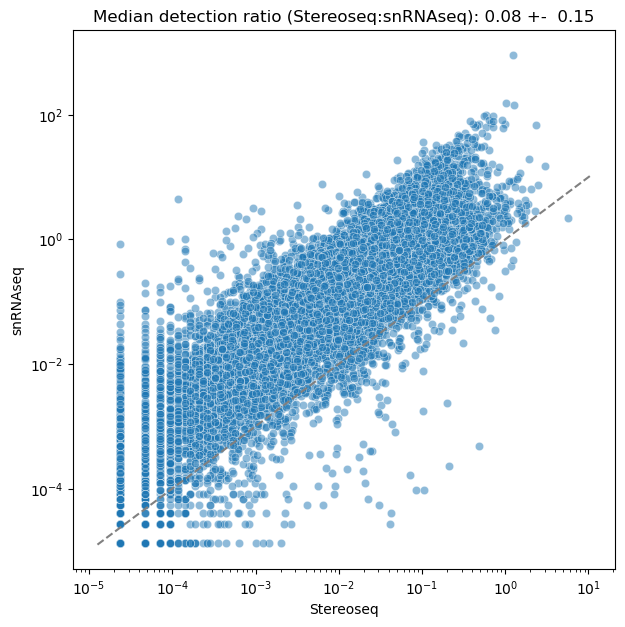

In [24]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(data=mean_expression, x='Stereoseq', y='snRNAseq', alpha=0.5, lw=0, ax=ax)
ax.set_yscale('log')
ax.set_xscale('log')
abline(1, 0, ax=ax, args={'ls': '--', 'c': 'grey'})
_ = ax.set_title(f'Median detection ratio (Stereoseq:snRNAseq):{mean_expression["Ratio"].median(): 0.2f} +- {mean_expression["Ratio"].sem(): 0.2f}')

# ax.set_ylim(-0.1, 10e2)
# ax.set_xlim(-0.1, 10e1)

MERSCOPE cell-wise comparison

In [25]:
import anndata as ad
ad_sp_merscope = ad.read_h5ad('C://Users/stephanies/data/human/H20.33.002/1190312477/1190312477.h5ad')

In [26]:
ad_sp_merscope.obs

cluster subclass    neighborhood  \
119312318312399308592808765882036649984        OPC_1      OPC            glia   
129092963804858012840780233995347558400      Astro_4    Astro            glia   
13081523917336282826187412605530800128       Astro_3    Astro            glia   
139647069223640830758063337696875511808        OPC_1      OPC            glia   
212436883047004740195223034869017739264  Micro/PVM_1       NA              NA   
...                                              ...      ...             ...   
199003855413777122051396486641181786112  Micro/PVM_1       NA              NA   
235725232649643756313337817746504679424       Sncg_3     Sncg  lamp5_sncg_vip   
40708206802269080103822195801156747264       Astro_4    Astro            glia   
145820514141779112885709810947279814656      Astro_1    Astro            glia   
301306707315358756837288007539953238016       Endo_1     Endo            glia   

                                        class   merscope   avg.cor  \
119312318312399308592808765882036649984  glia  Madison25  0.444383   
129092963804858012840780233995347558400  glia  Madison25  0.441284   
13081523917336282826187412605530800128   glia  Madison25  0.429229   
139647069223640830758063337696875511808  glia  Madison25  0.431692   
212436883047004740195223034869017739264    NA  Madison25  0.224002   
...                                       ...        ...       ...   
199003855413777122051396486641181786112    NA  Madison25  0.323474   
235725232649643756313337817746504679424   inh  Madison25  0.499208   
40708206802269080103822195801156747264   glia  Madison25  0.512982   
145820514141779112885709810947279814656  glia  Madison25  0.386087   
301306707315358756837288007539953238016  glia  Madison25  0.415948   

                                         genes_detected  total_reads  prob  \
119312318312399308592808765882036649984            47.0        136.0  1.00   
129092963804858012840780233995347558400            51.0        138.0  0.55   
13081523917336282826187412605530800128             48.0        178.0  1.00   
139647069223640830758063337696875511808            41.0         81.0  1.00   
212436883047004740195223034869017739264            24.0         69.0  0.96   
...                                                 ...          ...   ...   
199003855413777122051396486641181786112            17.0         43.0  1.00   
235725232649643756313337817746504679424            78.0        380.0  0.87   
40708206802269080103822195801156747264             52.0        180.0  0.76   
145820514141779112885709810947279814656            44.0        118.0  0.50   
301306707315358756837288007539953238016            44.0        128.0  1.00   

                                              volume  \
119312318312399308592808765882036649984   823.790455   
129092963804858012840780233995347558400   919.003692   
13081523917336282826187412605530800128    661.344460   
139647069223640830758063337696875511808   608.414684   
212436883047004740195223034869017739264  1488.131105   
...                                              ...   
199003855413777122051396486641181786112  1367.010665   
235725232649643756313337817746504679424  1200.527468   
40708206802269080103822195801156747264   1327.347231   
145820514141779112885709810947279814656  1553.583645   
301306707315358756837288007539953238016  1358.236420   

                                                                    section  \
119312318312399308592808765882036649984  H20.30.002.Cx30.MTG.02.007.1.01.01   
129092963804858012840780233995347558400  H20.30.002.Cx30.MTG.02.007.1.01.01   
13081523917336282826187412605530800128   H20.30.002.Cx30.MTG.02.007.1.01.01   
139647069223640830758063337696875511808  H20.30.002.Cx30.MTG.02.007.1.01.01   
212436883047004740195223034869017739264  H20.30.002.Cx30.MTG.02.007.1.01.01   
...                                                                     ...   
199003855413777122051396486641181786112  H20.30.002.Cx30.MTG.02.007.

In [28]:
merscope_genes = ad_sp_merscope.var.index.to_list()
print(len(merscope_genes))
merscope_genes = [g for g in merscope_genes if g in ad_sp.var.index.to_list()]
print(len(merscope_genes))
ad_sp_stereo_reduced_genes = ad_sp[:, merscope_genes]

140
139


In [42]:
[g for g in ad_sp_merscope.var.index.to_list() if g not in ad_sp.var.index.to_list()]

['TAFA1']

In [29]:
ad_sp.obs['n_merscope_transcripts'] = np.array(ad_sp_stereo_reduced_genes.X.sum(axis=1))
ad_sp.obs['n_merscope_genes'] = np.array(np.count_nonzero(ad_sp_stereo_reduced_genes.X, axis=1))
ad_sp.obs

x             y  n_spots  n_transcripts  n_genes  \
261     7626.802246   4729.047363    110.0          253.0    193.0   
285     8150.893555   4739.859375    131.0          413.0    280.0   
300     7991.510742   4756.812012    111.0          229.0    180.0   
340     7678.530762   4777.556152    110.0          277.0    206.0   
438     8017.916504   4881.809082    128.0          288.0    225.0   
...             ...           ...      ...            ...      ...   
49570   9634.883789  24505.720703    133.0          412.0    277.0   
49572  11042.689453  24500.250000    115.0          232.0    152.0   
49581  11139.636719  24518.414062    128.0          292.0    182.0   
49587  11790.439453  24534.582031    116.0          289.0    179.0   
49589  10334.294922  24531.728516    111.0          268.0    159.0   

       n_merscope_transcripts  n_merscope_genes  
261                       3.0                 2  
285                       8.0                 6  
300                       6.0                 4  
340                       1.0                 1  
438                       5.0                 4  
...                       ...               ...  
49570                     3.0                 2  
49572                     1.0                 1  
49581                     1.0                 1  
49587                     1.0                 1  
49589                     8.0                 6  

[42646 rows x 7 columns]

In [30]:
ad_sp.obs[['n_transcripts', 'n_merscope_transcripts']].describe()

n_transcripts  n_merscope_transcripts
count   42646.000000            42646.000000
mean     1021.026263               15.320686
std       823.491098               13.642988
min       200.000000                0.000000
25%       342.000000                5.000000
50%       727.000000               11.000000
75%      1516.000000               23.000000
max      4079.000000              172.000000

In [49]:
ad_sp_bin100 = ad.read_h5ad(data_path + '/903TR_C4/ad_sp_bin100.h5ad')
ad_sp_bin100.obs

x        y  n_transcripts  n_genes  n_cells
bin:4511_4569     4511.0   4569.0           12.0       12        3
bin:4511_4669     4511.0   4669.0           47.0       36        2
bin:4511_4769     4511.0   4769.0           90.0       61        0
bin:4511_4869     4511.0   4869.0          104.0       80        1
bin:4511_4969     4511.0   4969.0          113.0       92        3
...                  ...      ...            ...      ...      ...
bin:20411_16369  20411.0  16369.0         2074.0     1160        1
bin:20411_16469  20411.0  16469.0         1599.0      882        1
bin:20411_16569  20411.0  16569.0          409.0      238        0
bin:20511_16069  20511.0  16069.0          905.0      568        0
bin:20511_16169  20511.0  16169.0          138.0       99        0

[18942 rows x 5 columns]

In [59]:
bin100_transcripts = np.array(ad_sp_bin100[:, merscope_genes].X.sum(axis=1))
bin100_genes = np.array(np.count_nonzero(ad_sp_bin100[:, merscope_genes].X, axis=1))
bin100_counts = pd.DataFrame({'n_transcripts': bin100_transcripts, 'n_genes': bin100_genes})
bin100_counts['method'] = 'stereoseq_bin100'
bin100_counts

n_transcripts  n_genes            method
0                0.0        0  stereoseq_bin100
1                0.0        0  stereoseq_bin100
2                0.0        0  stereoseq_bin100
3                0.0        0  stereoseq_bin100
4                3.0        3  stereoseq_bin100
...              ...      ...               ...
18937           23.0       13  stereoseq_bin100
18938           10.0        8  stereoseq_bin100
18939            3.0        3  stereoseq_bin100
18940            8.0        7  stereoseq_bin100
18941            3.0        3  stereoseq_bin100

[18942 rows x 3 columns]

In [50]:
ad_sp_bin50 = ad.read_h5ad(data_path + '/903TR_C4/ad_sp_bin50_2.h5ad')

In [60]:
bin50_transcripts = np.array(ad_sp_bin50[:, merscope_genes].X.sum(axis=1))
bin50_genes = np.array(np.count_nonzero(ad_sp_bin50[:, merscope_genes].X, axis=1))
bin50_counts = pd.DataFrame({'n_transcripts': bin50_transcripts, 'n_genes': bin50_genes})
bin50_counts['method'] = 'stereoseq_bin50'
bin50_counts

n_transcripts  n_genes           method
0                1.0        1  stereoseq_bin50
1                9.0        6  stereoseq_bin50
2                5.0        3  stereoseq_bin50
3                1.0        1  stereoseq_bin50
4                3.0        3  stereoseq_bin50
...              ...      ...              ...
30806            3.0        2  stereoseq_bin50
30807            6.0        6  stereoseq_bin50
30808            4.0        2  stereoseq_bin50
30809            4.0        4  stereoseq_bin50
30810            4.0        3  stereoseq_bin50

[30811 rows x 3 columns]

In [68]:
cell_gene_compare = ad_sp.obs[['n_merscope_transcripts', 'n_merscope_genes']]
cell_gene_compare.rename(columns={'n_merscope_transcripts': 'total_reads', 'n_merscope_genes': 'genes_detected'}, inplace=True)
cell_gene_compare['method'] = 'stereoseq_cell'
merscope_obs = ad_sp_merscope.obs[['total_reads', 'genes_detected']]
merscope_obs['method'] = 'MERSCOPE'
cell_gene_compare = cell_gene_compare.append(merscope_obs)
cell_gene_compare.rename(columns={'total_reads': 'n_transcripts', 'genes_detected': 'n_genes'}, inplace=True)
cell_gene_compare = cell_gene_compare.append(bin100_counts)
cell_gene_compare = cell_gene_compare.append(bin50_counts)
cell_gene_compare

C:\Users\stephanies\AppData\Local\Temp\ipykernel_18728\249815206.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_gene_compare.rename(columns={'n_merscope_transcripts': 'total_reads', 'n_merscope_genes': 'genes_detected'}, inplace=True)
C:\Users\stephanies\AppData\Local\Temp\ipykernel_18728\249815206.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_gene_compare['method'] = 'stereoseq_cell'
C:\Users\stephanies\AppData\Local\Temp\ipykernel_18728\249815206.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

n_transcripts  n_genes           method
261              3.0      2.0   stereoseq_cell
285              8.0      6.0   stereoseq_cell
300              6.0      4.0   stereoseq_cell
340              1.0      1.0   stereoseq_cell
438              5.0      4.0   stereoseq_cell
...              ...      ...              ...
30806            3.0      2.0  stereoseq_bin50
30807            6.0      6.0  stereoseq_bin50
30808            4.0      2.0  stereoseq_bin50
30809            4.0      4.0  stereoseq_bin50
30810            4.0      3.0  stereoseq_bin50

[110229 rows x 3 columns]

In [62]:
cell_gene_compare.groupby('method').describe().T

method                   MERSCOPE  stereoseq cell  stereoseq_bin100  \
n_transcripts count  17830.000000    42646.000000      18942.000000   
              mean     283.434268       15.320687         47.455232   
              std      311.361509       13.642989         35.565938   
              min       30.000000        0.000000          0.000000   
              25%       87.000000        5.000000         16.000000   
              50%      167.000000       11.000000         41.000000   
              75%      334.000000       23.000000         74.000000   
              max     2326.000000      172.000000        246.000000   
n_genes       count  17830.000000    42646.000000      18942.000000   
              mean      51.740606        9.054894         22.699081   
              std       26.066984        6.670220         12.856374   
              min        4.000000        0.000000          0.000000   
              25%       30.000000        4.000000         11.000000   
              50%       46.000000        7.000000         22.000000   
              75%       72.000000       14.000000         33.000000   
              max      123.000000       40.000000         63.000000   

method               stereoseq_bin50  
n_transcripts count     30811.000000  
              mean         14.673331  
              std           9.506500  
              min           0.000000  
              25%           7.000000  
              50%          14.000000  
              75%          20.000000  
              max         118.000000  
n_genes       count     30811.000000  
              mean          8.827432  
              std           4.750180  
              min           0.000000  
              25%           5.000000  
              50%           9.000000  
              75%          12.000000  
              max          35.000000

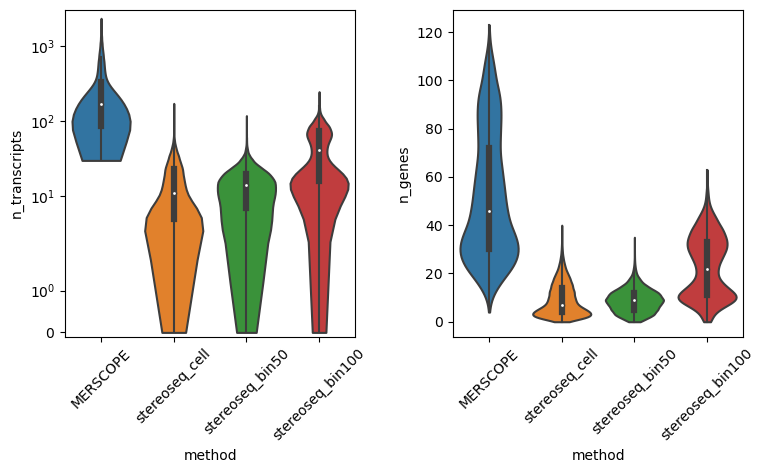

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
order = ['MERSCOPE', 'stereoseq_cell', 'stereoseq_bin50', 'stereoseq_bin100']
sns.violinplot(data=cell_gene_compare, x='method', y='n_genes', ax=ax[1], cut=0, scale='width', order=order)
sns.violinplot(data=cell_gene_compare, x='method', y='n_transcripts', ax=ax[0], cut=0, scale='width', order=order)
plt.tight_layout()
ax[0].set_yscale('symlog')
ax[0].set_ylim(-0.1, 3e3)
ax[0].tick_params(axis='x', labelrotation=45)
ax[1].tick_params(axis='x', labelrotation=45)

<AxesSubplot:xlabel='x', ylabel='y'>

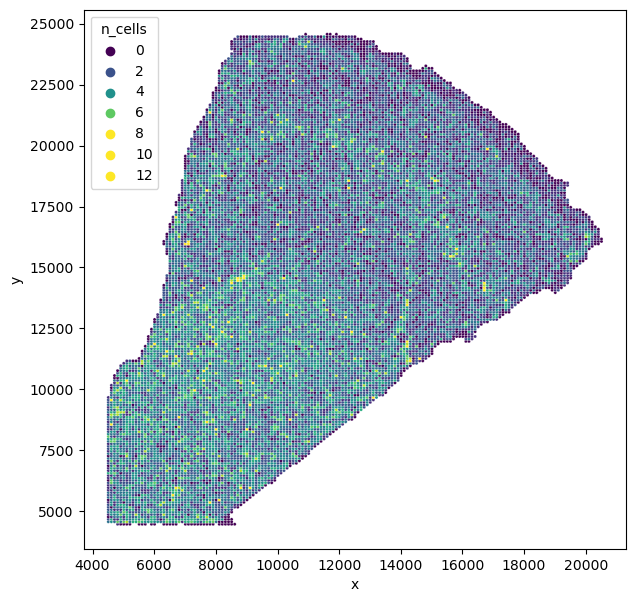

In [73]:
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(data=ad_sp_bin100.obs, x='x', y='y', hue='n_cells', palette='viridis', s=5, ax=ax, hue_norm=(0, 8))

In [74]:
ad_sp_bin100.obs['n_cells']/ad_sp_bin100.obs['n_cells'].sum()

bin:4511_4569      0.000061
bin:4511_4669      0.000040
bin:4511_4769      0.000000
bin:4511_4869      0.000020
bin:4511_4969      0.000061
                     ...   
bin:20411_16369    0.000020
bin:20411_16469    0.000020
bin:20411_16569    0.000000
bin:20511_16069    0.000000
bin:20511_16169    0.000000
Name: n_cells, Length: 18942, dtype: float64

Move to celltype_mapping/human-stereoseq-cell-mapping notebook for mapping